# Forecaster with Deep Learning

## Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)

Recurrent Neural Networks (RNN) are a type of neural networks designed to process data that follows a sequential order. In conventional neural networks, such as feedforward networks, information flows in one direction, from input to output through hidden layers, without considering the sequential structure of the data. In contrast, RNNs maintain internal states or memories, which allow them to remember past information and use it to predict future data in the sequence.

The basic unit of an RNN is the recurrent cell. This cell takes two inputs: the current input and the previous hidden state. The hidden state can be understood as a "memory" that retains information from previous iterations. The current input and the previous hidden state are combined to calculate the current output and the new hidden state. This output is used as input for the next iteration, along with the next input in the data sequence.

Despite the advances that have been achieved with RNN architectures, they have limitations to capture long-term patterns. This is why variants such as  Long Short-Term Memory (LSTM) and Gated Recurrent Units (GRU) have been developed, which address these problems and allow long-term information to be retained more effectively.

<p align="center"><img src='../img/schema-rnn-model.jpg'style="width: 600px"></p>


<center><font size='2.5'> <i>RNN diagram. Fuente: James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (1st ed.) [PDF]. Springer.</i></font></center>


Long Short-Term Memory (LSTM) neural networks are a specialized type of RNNs designed to overcome the limitations associated with capturing long-term temporal dependencies. Unlike traditional RNNs, LSTMs incorporate a more complex architecture, introducing memory units and gate mechanisms to improve information management over time.

**Structure of LSTMs**

LSTMs have a modular structure consisting of three fundamental gates: the forget gate, the input gate, and the output gate. These gates work together to regulate the flow of information through the memory unit, allowing for more precise control over what information to retain and what to forget.

+ **Forget Gate:** Regulates how much information should be forgotten and how much should be retained, combining the current input and the previous output through a sigmoid function.

+ **Input Gate:** Decides how much new information should be added to long-term memory.

+ **Output Gate:** Determines how much information from the current memory will be used for the final output, combining the current input and memory information through a sigmoid function.



<p align="center"><img src='https://databasecamp.de/wp-content/uploads/lstm-architecture-1024x709.png'style="width: 400px"></p>

<center><font size='2.5'> <i>Diagram of the inputs and outputs of an LSTM. Fuente: codificandobits https://databasecamp.de/wp-content/uploads/lstm-architecture-1024x709.png.</i></font></center>


<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

To learn more about forecasting with deep learning  models visit our examples:

<ul>
    <li>
    <a href="https://www.cienciadedatos.net/documentos/py54-forecasting-with-deep-learning.html">Deep Learning for time series forecasting: Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)</a>.
    </li>
</ul>

</div>

## Libraries and data

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>


As of Skforecast version <code>0.13.0</code>, PyTorch backend support is available. You can configure the backend by exporting the <code>KERAS_BACKEND</code> environment variable or by editing your local configuration file at <code>~/.keras/keras.json</code>. The available backend options are: "tensorflow", "jax" and "torch".

```python
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # 'tensorflow', 'jax' or 'torch'
import keras
```

The backend must be configured before importing Keras and cannot be changed after importing the package.

Tensorflow 2.18 is only supported in Python 3.12 or lower.

</div>

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent.parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd

c:\Users\jaesc2\GitHub\skforecast


In [2]:
# Libraries
# ==============================================================================
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # 'tensorflow', 'jax´ or 'torch'
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import skforecast
from skforecast.plot import set_dark_theme
from skforecast.datasets import fetch_dataset
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries

from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('once')

print(f"skforecast version: {skforecast.__version__}")
print(f"keras version: {keras.__version__}")

if keras.__version__ > "3.0":
    print(f"Using backend: {keras.backend.backend()}")
    if keras.backend.backend() == "tensorflow":
        import tensorflow
        print(f"tensorflow version: {tensorflow.__version__}")
    elif keras.backend.backend() == "torch":
        import torch
        print(f"torch version: {torch.__version__}")
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

skforecast version: 0.17.0
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0


In [ ]:
# Data download
# ==============================================================================
data = fetch_dataset(name="air_quality_valencia_no_missing")
data.head()

KeyboardInterrupt: 

In [4]:
data = pd.read_csv(
    r"C:\Users\jaesc2\Downloads\air_quality_valencia_no_missing.csv", sep=','
)
data = data.set_index('datetime')
data.index = pd.to_datetime(data.index, format='%Y-%m-%d %H:%M:%S')
data = data.asfreq('h')
data = data.sort_index()

In [5]:
# Checking the frequency of the time series
# ==============================================================================
print(f"Index: {data.index.dtype}")
print(f"Frequency: {data.index.freq}")

Index: datetime64[ns]
Frequency: <Hour>


In [6]:
# Split train-validation-test
# ==============================================================================
data = data.loc["2019-01-01 00:00:00":"2021-12-31 23:59:59", :].copy()

end_train = "2021-03-31 23:59:00"
end_validation = "2021-09-30 23:59:00"
data_train = data.loc[:end_train, :].copy()
data_val = data.loc[end_train:end_validation, :].copy()
data_test = data.loc[end_validation:, :].copy()

print(
    f"Dates train      : {data_train.index.min()} --- " 
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Dates validation : {data_val.index.min()} --- " 
    f"{data_val.index.max()}  (n={len(data_val)})"
)
print(
    f"Dates test       : {data_test.index.min()} --- " 
    f"{data_test.index.max()}  (n={len(data_test)})"
)

Dates train      : 2019-01-01 00:00:00 --- 2021-03-31 23:00:00  (n=19704)
Dates validation : 2021-04-01 00:00:00 --- 2021-09-30 23:00:00  (n=4392)
Dates test       : 2021-10-01 00:00:00 --- 2021-12-31 23:00:00  (n=2208)


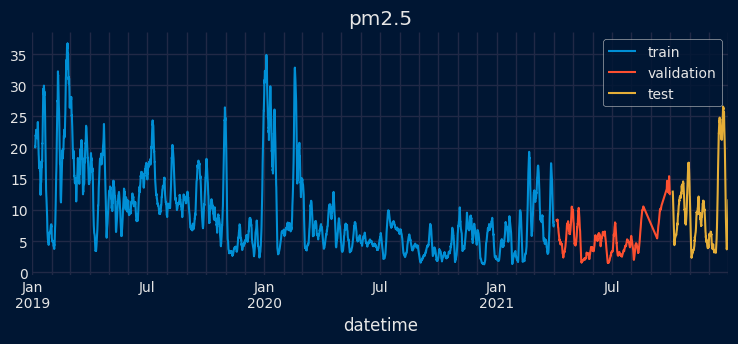

In [7]:
# Plotting one feature
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(8, 3))
data_train["pm2.5"].rolling(100).mean().plot(ax=ax, label="train")
data_val["pm2.5"].rolling(100).mean().plot(ax=ax, label="validation")
data_test["pm2.5"].rolling(100).mean().plot(ax=ax, label="test")
ax.set_title("pm2.5")
ax.legend();

## Types of problems in time series modeling

### 1:1 Single-Step Forecasting - Predict one step ahead of a single series using the same series as predictor.


This type of problem involves modeling a time series using only its own past. It is a typical autoregressive problem.

Although tensorflow-keras facilitates the process of creating *deep learning* architectures, it is not always trivial to determine the Xtrain and Ytrain dimensions requiered to run an LSTM model. The dimensions depend on how many time series are being modeled, how many of them are are used as predictors, and the length of the prediction horizon.


<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The `create_and_compile_model` function is designed to facilitate the creation of the Tensorflow model. Advanced users can create their own architectures and pass them to the skforecast RNN Forecaster. Input and output dimensions must match the use case to which the model will be applied. the Annex at the end of the document for more details.

</div>

In [ ]:
# Create model
# ==============================================================================
model = create_and_compile_model(
    series=data[["o3"]],  # Series used as predictors
    levels=["o3"],      # Target series to predict
    lags=32,
    steps=1,
    recurrent_layer="LSTM",
    recurrent_units=[100, 100, 100, 100],
    recurrent_layers_kwargs={"activation": "tanh"},
    dense_units=[64, 32, 16, 8],
    dense_layers_kwargs={"activation": "relu"},
    output_dense_layer_kwargs={"activation": "linear"},
    compile_kwargs={"optimizer": Adam(learning_rate=0.01), "loss": MeanSquaredError()},
)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 5, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_td_1 (TimeDistributed)    │ (None, 5, 64)          │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_td_2 (TimeDistributed)    │ (None, 5, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_td_3 (TimeDistributed)    │ (None, 5, 16)          │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_td_4 (TimeDistributed)    │ (None, 5, 8)           │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer           │ (None, 5, 1)           │             9 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291,217 (1.11 MB)

 Trainable params: 291,217 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Forecaster Definition
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=["o3"],
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 3,  # Number of epochs to train the model.
        "batch_size": 2048,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)    

forecaster

c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\keras\src\backend\tensorflow\core.py:143: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


============= 
ForecasterRnn 
============= 
Regressor: <Functional name=functional_4, built=True> 
Layers names: ['series_input', 'lstm_1', 'lstm_2', 'lstm_3', 'lstm_4', 'repeat_vector', 'dense_td_1', 'dense_td_2', 'dense_td_3', 'dense_td_4', 'output_dense_td_layer'] 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Window size: 32 
Maximum steps to predict: [1 2 3 4 5] 
Series names: None 
Target series (levels): ['o3'] 
Exogenous included: False 
Exogenous names: None 
Transformer for series: MinMaxScaler() 
Transformer for exog: MinMaxScaler() 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'name': 'functional_4', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'name': 'series_input'}, 'registered_name': None, 'name': 'series_input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 100, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'OrthogonalInitializer', 'config': {'seed': None, 'gain': 1.0}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 1]}, 'name': 'lstm_1', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 1), 'dtype': 'float32', 'keras_history': ['series_input', 0, 0]}},), 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 100, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'OrthogonalInitializer', 'config': {'seed': None, 'gain': 1.0}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 100]}, 'name': 'lstm_2', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 100), 'dtype': 'float32', 'keras_history': ['lstm_1', 0, 0]}},), 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_3', 'trainable': True, 'dtype': {'module': 'keras', '

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>


The output warning indicates that the number of lags has been inferred from the model architecture. In this case, the model has an LSTM layer with 32 neurons, so the number of lags is 32. If a different number of lags is desired, the `lags` argument can be specified in the `create_and_compile_model` function.
To omit the warning, set `lags=lags` and `steps=steps` arguments can be specified in the initialization of the `ForecasterRnn`.

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The **skforecast** library is fully compatible with GPUs. See the **Running in GPU** section below in this document for more information.
</div>

In [47]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train[['o3']])

Using device: cuda
Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.1786 - val_loss: 0.0311
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.0431 - val_loss: 0.0370
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.0412 - val_loss: 0.0465


Overfitting can be tracked by moniting the loss function on the validation set. Metrics are automatically stored in the `history` attribute of the `ForecasterRnn` object. The method `plot_history` can be used to visualize the training and validation loss.

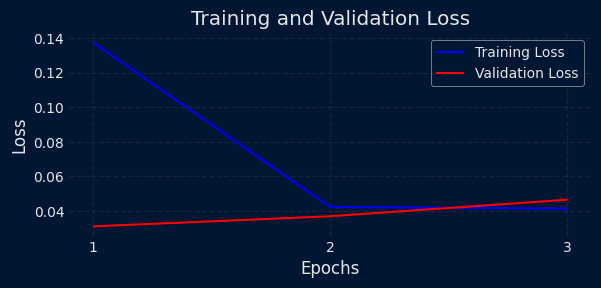

In [48]:
# Track training and overfitting
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
_ = forecaster.plot_history(ax=ax)

In [50]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()
predictions

,level,pred
2021-04-01 00:00:00,o3,47.994816
2021-04-01 01:00:00,o3,47.994816
2021-04-01 02:00:00,o3,47.994816
2021-04-01 03:00:00,o3,47.994816
2021-04-01 04:00:00,o3,47.994816


In [17]:
# Backtesting with test data
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster  = forecaster,
    series      = data[['o3']],
    cv          = cv,
    levels      = forecaster.levels,
    metric      = "mean_absolute_error",
)

c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\keras\src\backend\tensorflow\core.py:143: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)


Using device: cuda
Epoch 1/3


c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\tensorflow\python\util\tf_stack.py:162: ResourceWarning: unclosed <socket.socket fd=5796, family=23, type=1, proto=0, laddr=('::', 60951, 0, 0)>
  return _tf_stack.extract_stack(


12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0399 - val_loss: 0.0383
Epoch 2/3
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0386 - val_loss: 0.0297
Epoch 3/3
12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0374 - val_loss: 0.0354


  0%|          | 0/2208 [00:00<?, ?it/s]

In [18]:
# Backtesting predictions
# ==============================================================================
predictions

,level,pred
2021-10-01 00:00:00,o3,55.115292
2021-10-01 01:00:00,o3,55.138290
2021-10-01 02:00:00,o3,55.161163
2021-10-01 03:00:00,o3,55.182755
2021-10-01 04:00:00,o3,55.201321
...,...,...
2021-12-31 19:00:00,o3,51.174343
2021-12-31 20:00:00,o3,51.246052
2021-12-31 21:00:00,o3,51.313591
2021-12-31 22:00:00,o3,51.361275


In [21]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Serie mean: 54.52
Relative error (mae): 32.52 %


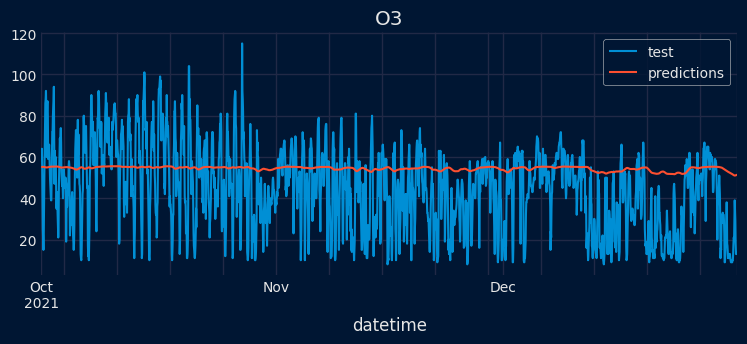

In [22]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data_test["o3"].plot(ax=ax, label="test")
predictions.loc[predictions["level"] == "o3", "pred"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend();

### 1:1 Multiple-Step Forecasting - Predict a single series using the same series as predictor. Multiple steps ahead.



The next case is similar to the previous one, but now the goal is to predict multiple future values. In this scenario multiple future steps of a single time series are modeled using only its past values.

A similar architecture to the previous one will be used, but with a greater number of neurons in the LSTM layer and in the first dense layer. This will allow the model to have greater flexibility to predict the time series.

In [ ]:
# Model creation
# ==============================================================================
model = create_and_compile_model(
    series=data[["o3"]],  # Series used as predictors
    levels=["o3"],        # Target series to predict
    lags=32,              # Past time steps to be used to predict the target
    steps=5,              # Future time steps to be predicted
    recurrent_layer="LSTM",
    recurrent_units=50,
    recurrent_layers_kwargs={"activation": "tanh"},
    dense_units=32,
    dense_layers_kwargs={"activation": "relu"},
    output_dense_layer_kwargs={"activation": "linear"},
    compile_kwargs={"optimizer": Adam(learning_rate=0.01), "loss": MeanSquaredError()},
)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 5, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_td_1 (TimeDistributed)    │ (None, 5, 32)          │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_td_layer           │ (None, 5, 1)           │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,065 (47.13 KB)

 Trainable params: 12,065 (47.13 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor          = model,
    levels             = ['o3'],
    transformer_series = MinMaxScaler(),
    fit_kwargs         = {
                            "epochs": 5,  # Number of epochs to train the model.
                            "batch_size": 1024,  # Batch size to train the model.
                            "callbacks": [
                                EarlyStopping(monitor="val_loss", patience=5)
                            ],  # Callback to stop training when it is no longer learning.
                            "series_val": data_val,  # Validation data for model training.
                        },
)    

forecaster

c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\keras\src\backend\tensorflow\core.py:143: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  return np.array(x)
c:\Users\jaesc2\Miniconda3\envs\skforecast_py11_2\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 16 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


============= 
ForecasterRnn 
============= 
Regressor: <Functional name=functional_2, built=True> 
Layers names: ['series_input', 'lstm_1', 'repeat_vector', 'dense_td_1', 'output_dense_td_layer'] 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Window size: 32 
Maximum steps to predict: [1 2 3 4 5] 
Series names: None 
Target series (levels): ['o3'] 
Exogenous included: False 
Exogenous names: None 
Transformer for series: MinMaxScaler() 
Transformer for exog: MinMaxScaler() 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'name': 'functional_2', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 1), 'dtype': 'float32', 'sparse': False, 'name': 'series_input'}, 'registered_name': None, 'name': 'series_input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 50, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'OrthogonalInitializer', 'config': {'seed': None, 'gain': 1.0}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 32, 1]}, 'name': 'lstm_1', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 32, 1), 'dtype': 'float32', 'keras_history': ['series_input', 0, 0]}},), 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'RepeatVector', 'config': {'name': 'repeat_vector', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'n': 5}, 'registered_name': None, 'build_config': {'input_shape': [None, 50]}, 'name': 'repeat_vector', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 50), 'dtype': 'float32', 'keras_history': ['lstm_1', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'TimeDistributed', 'config': {'name': 'dense_td_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layer': {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 50]}}}, 'registered_name': None, 'build_config': {'input_shape': [None, 5, 50]}, 'name': 'dense_td_1', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 5, 50), 'dty

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The `fit_kwargs` parameter allows the user to set any Tensorflow-based configuration in the model. In the example, 10 training epochs are defined with a batch size of 32. An `EarlyStopping` callback is configured to stop training when the validation loss stops decreasing for 5 epochs (`patience=5`). Other callbacks can also be configured, such as `ModelCheckpoint` to save the model at each epoch, or even Tensorboard to visualize the training and validation loss in real time.

</div>

In [30]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train[['o3']])

Using device: cuda
Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 0.0738 - val_loss: 0.0258
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - loss: 0.0271 - val_loss: 0.0259
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0240 - val_loss: 0.0234
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0218 - val_loss: 0.0187
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0186 - val_loss: 0.0173


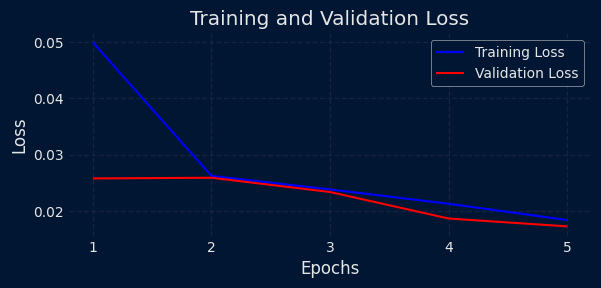

In [31]:
# Train and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
_ = forecaster.plot_history(ax=ax)

In [39]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

[[[0.58646617]
  [0.57142857]
  [0.59398496]
  [0.55639098]
  [0.51879699]
  [0.53383459]
  [0.5112782 ]
  [0.32330827]
  [0.2556391 ]
  [0.2481203 ]
  [0.23308271]
  [0.11278195]
  [0.09022556]
  [0.05263158]
  [0.01503759]
  [0.02255639]
  [0.03759398]
  [0.12030075]
  [0.34586466]
  [0.41353383]
  [0.46616541]
  [0.53383459]
  [0.57894737]
  [0.55639098]
  [0.67669173]
  [0.65413534]
  [0.60150376]
  [0.57142857]
  [0.54887218]
  [0.5037594 ]
  [0.41353383]
  [0.34586466]]]
[[[0.2867782]
  [0.2867782]
  [0.2867782]
  [0.2867782]
  [0.2867782]]]
[[0.2867782]
 [0.2867782]
 [0.2867782]
 [0.2867782]
 [0.2867782]]


,level,pred
2021-04-01 00:00:00,o3,42.141502
2021-04-01 01:00:00,o3,42.141502
2021-04-01 02:00:00,o3,42.141502
2021-04-01 03:00:00,o3,42.141502
2021-04-01 04:00:00,o3,42.141502


In [32]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,level,pred
2021-04-01 00:00:00,o3,42.141502
2021-04-01 01:00:00,o3,42.141502
2021-04-01 02:00:00,o3,42.141502
2021-04-01 03:00:00,o3,42.141502
2021-04-01 04:00:00,o3,42.141502


In [33]:
# Specific step predictions
# ==============================================================================
predictions = forecaster.predict(steps=[1, 3])
predictions

,level,pred
2021-04-01 00:00:00,o3,42.141502
2021-04-01 02:00:00,o3,42.141502


In [ ]:
# Backtesting 
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
     )

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster = forecaster,
    series     = data[['o3']],
    cv         = cv,
    levels     = forecaster.levels,
    metric     = "mean_absolute_error",
)

Epoch 1/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0232 - val_loss: 0.0179
Epoch 2/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 0.0177 - val_loss: 0.0202
Epoch 3/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0173 - val_loss: 0.0149


  0%|          | 0/442 [00:00<?, ?it/s]

In [23]:
# Backtesting predictions
# ==============================================================================
predictions

,level,pred
2021-10-01 00:00:00,o3,50.835548
2021-10-01 01:00:00,o3,50.480816
2021-10-01 02:00:00,o3,50.013161
2021-10-01 03:00:00,o3,49.361664
2021-10-01 04:00:00,o3,49.007488
...,...,...
2021-12-31 19:00:00,o3,30.627413
2021-12-31 20:00:00,o3,29.340004
2021-12-31 21:00:00,o3,10.848275
2021-12-31 22:00:00,o3,10.269327


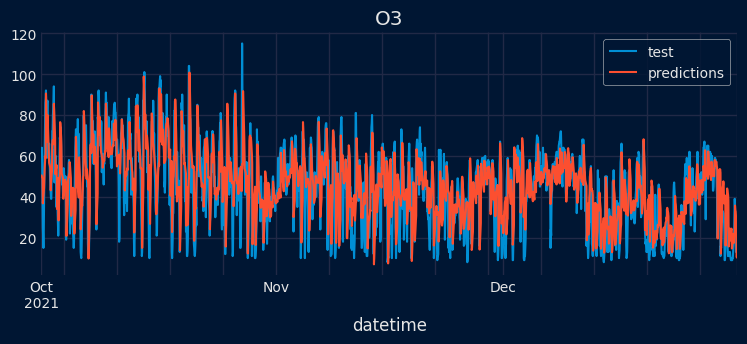

In [24]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data_test["o3"].plot(ax=ax, label="test")
predictions.loc[predictions["level"] == "o3", "pred"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend();

In [25]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,o3,11.356001


In [26]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Serie mean: 54.52
Relative error (mae): 20.83 %


### N:1 Multiple-Step Forecasting - Predict one series using multiple series as predictors.

In this case, a single series will be predicted, but using multiple time series as predictors. Now, the past values of multiple time series will influence the prediction of a single time series.

In [27]:
# Model creation
# ==============================================================================
# Time series used in the training. Now, it is multiseries
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2'] 
levels = ["o3"] 
lags = 32 
steps = 5 

data       = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val   = air_quality_val[series].copy()
data_test  = air_quality_test[series].copy()

model = create_and_compile_model(
    series          = data_train,
    levels          = levels, 
    lags            = lags,
    steps           = steps,
    recurrent_layer = "LSTM",
    recurrent_units = [100, 50],
    dense_units     = [64, 32],
    optimizer       = Adam(learning_rate=0.01), 
    loss            = MeanSquaredError()
)
model.summary()

keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32, 100)        │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 5, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,109 (312.93 KB)

 Trainable params: 80,109 (312.93 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Forecaster creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor          = model,
    levels             = levels,
    steps              = steps,
    lags               = lags,
    transformer_series = MinMaxScaler(),
    fit_kwargs         ={
                            "epochs": 4,  
                            "batch_size": 1024,  
                            "series_val": data_val,
                        },
)
forecaster

ForecasterRnn 
Regressor: <Functional name=functional_2, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_2', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 10), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_2'}, 'registered_name': None, 'name': 'input_layer_2', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_5', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': True, 'return_state': False, 'go_backwards': 

In [29]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - loss: 0.1802 - val_loss: 0.0363
Epoch 2/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0364 - val_loss: 0.0420
Epoch 3/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0304 - val_loss: 0.0343
Epoch 4/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0269 - val_loss: 0.0281


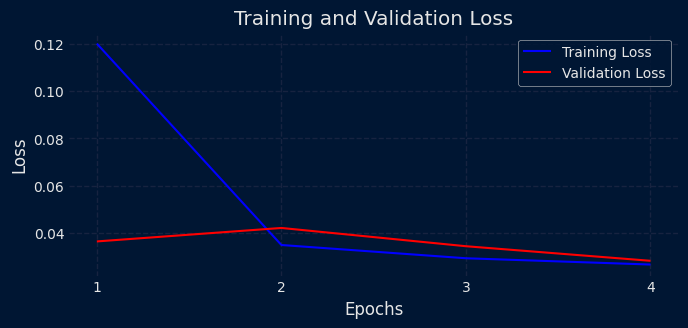

In [30]:
# Trainig and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
forecaster.plot_history(ax=ax)

In [31]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,level,pred
2021-04-01 00:00:00,o3,58.299496
2021-04-01 01:00:00,o3,59.188473
2021-04-01 02:00:00,o3,57.718353
2021-04-01 03:00:00,o3,60.647652
2021-04-01 04:00:00,o3,59.165234


In [32]:
# Backtesting with test data
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster = forecaster,
    series     = data,
    cv         = cv,
    levels     = forecaster.levels,
    metric     ="mean_absolute_error",
    verbose    = False
)

Epoch 1/4
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.0230 - val_loss: 0.0202
Epoch 2/4
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0167 - val_loss: 0.0142
Epoch 3/4
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.0141 - val_loss: 0.0128
Epoch 4/4
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 0.0129 - val_loss: 0.0129


  0%|          | 0/442 [00:00<?, ?it/s]

In [33]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,o3,13.765139


In [34]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Serie mean: 54.52
Relative error (mae): 25.25 %


In [35]:
# Backtesting predictions
# ==============================================================================
predictions

,level,pred
2021-10-01 00:00:00,o3,55.048229
2021-10-01 01:00:00,o3,51.521156
2021-10-01 02:00:00,o3,50.589493
2021-10-01 03:00:00,o3,49.430103
2021-10-01 04:00:00,o3,51.126389
...,...,...
2021-12-31 19:00:00,o3,48.851841
2021-12-31 20:00:00,o3,45.636745
2021-12-31 21:00:00,o3,7.257865
2021-12-31 22:00:00,o3,15.753617


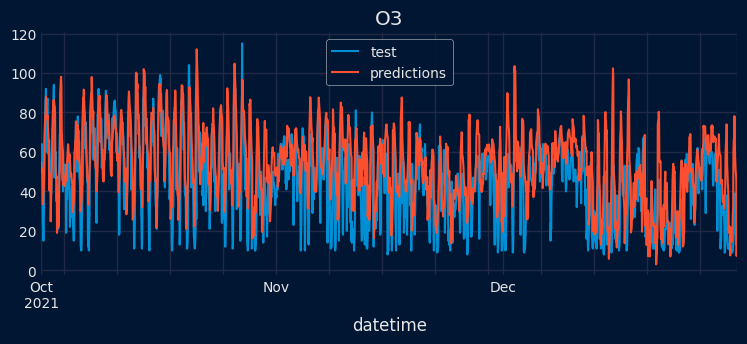

In [36]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data_test["o3"].plot(ax=ax, label="test")
predictions.loc[predictions["level"] == "o3", "pred"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend();


### N:M Multiple-Step Forecasting - Multiple time series with multiple outputs

This is a more complex scenario in which multiple time series are predicted using multiple time series as predictors. It is therefore a scenario in which multiple series are modeled simultaneously using a single model. This has special application in many real scenarios, such as the prediction of stock values for several companies based on the stock history, the price of energy and commodities. Or the case of forecasting multiple products in an online store, based on the sales of other products, the price of the products, etc.

In [37]:
# Model creation
# ==============================================================================
# Now, we have multiple series and multiple targets
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2'] 
levels = ['pm2.5', 'co', 'no', "o3"]  # Features to predict. It can be all the series or less
lags   = 32 
steps  = 5 

data       = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val   = air_quality_val[series].copy()
data_test  = air_quality_test[series].copy()

model = create_and_compile_model(
    series          = data_train,
    levels          = levels, 
    lags            = lags,
    steps           = steps,
    recurrent_layer = "LSTM",
    recurrent_units = [100, 50],
    dense_units     = [64, 32],
    optimizer       = Adam(learning_rate=0.01), 
    loss            = MeanSquaredError()
)
model.summary()

keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32, 100)        │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 5, 4)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,604 (314.86 KB)

 Trainable params: 80,604 (314.86 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Forecaster creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor          = model,
    levels             = levels,
    steps              = steps,
    lags               = lags,
    transformer_series = MinMaxScaler(),
    fit_kwargs         = {
                            "epochs": 10, 
                            "batch_size": 1024, 
                            "callbacks": [
                                EarlyStopping(monitor="val_loss", patience=3)
                            ],  
                            "series_val": data_val,
                        },
)
forecaster

ForecasterRnn 
Regressor: <Functional name=functional_3, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32] 
Transformer for series: MinMaxScaler() 
Window size: 32 
Target series, levels: ['pm2.5', 'co', 'no', 'o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_3', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 32, 10), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_3'}, 'registered_name': None, 'name': 'input_layer_3', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_7', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': True, 'return_state': Fa

In [39]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.0290 - val_loss: 0.0193
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 0.0107 - val_loss: 0.0169
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - loss: 0.0090 - val_loss: 0.0121
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0074 - val_loss: 0.0126
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 0.0063 - val_loss: 0.0113
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - loss: 0.0058 - val_loss: 0.0105
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0050 - val_loss: 0.0098
Epoch 9/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0046 - val_loss: 0.0094
Epoch 10/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - loss: 0.0044 - val_loss: 0.0094


The prediction can also be made for specific `steps`, as long as they are within the prediction horizon defined in the model.

In [40]:
# Specific step predictions
# ==============================================================================
forecaster.predict(steps=[1, 5], levels="o3")

,level,pred
2021-04-01 00:00:00,o3,41.249187
2021-04-01 04:00:00,o3,14.226887


In [41]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,level,pred
2021-04-01 00:00:00,co,0.128151
2021-04-01 00:00:00,no,0.711820
2021-04-01 00:00:00,o3,41.249187
2021-04-01 00:00:00,pm2.5,13.165507
2021-04-01 01:00:00,co,0.131857
2021-04-01 01:00:00,no,1.148177
2021-04-01 01:00:00,o3,39.203976
2021-04-01 01:00:00,pm2.5,13.617206
2021-04-01 02:00:00,co,0.108023
2021-04-01 02:00:00,no,-0.384001


In [42]:
# Backtesting with test data
# ==============================================================================
cv = TimeSeriesFold(
         steps              = forecaster.max_step,
         initial_train_size = len(data.loc[:end_validation, :]),  # Training + Validation Data
         refit              = False
     )

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster =forecaster,
    series     = data,
    cv         = cv,
    levels     = forecaster.levels,
    metric     = "mean_absolute_error",
    verbose    = False
)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - loss: 0.0041 - val_loss: 0.0088
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - loss: 0.0039 - val_loss: 0.0084
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.0038 - val_loss: 0.0077
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.0038 - val_loss: 0.0078
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - loss: 0.0036 - val_loss: 0.0068
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 0.0034 - val_loss: 0.0069
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.0034 - val_loss: 0.0069
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.0033 - val_loss: 0.0065
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 215ms/step - loss: 0.0033 - val_loss: 0.0068
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 0.0032 - val_loss: 0.0064


  0%|          | 0/442 [00:00<?, ?it/s]

In [43]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,pm2.5,3.254345
1,co,0.032351
2,no,3.056271
3,o3,11.427024
4,average,4.442498
5,weighted_average,4.442498
6,pooling,4.442498


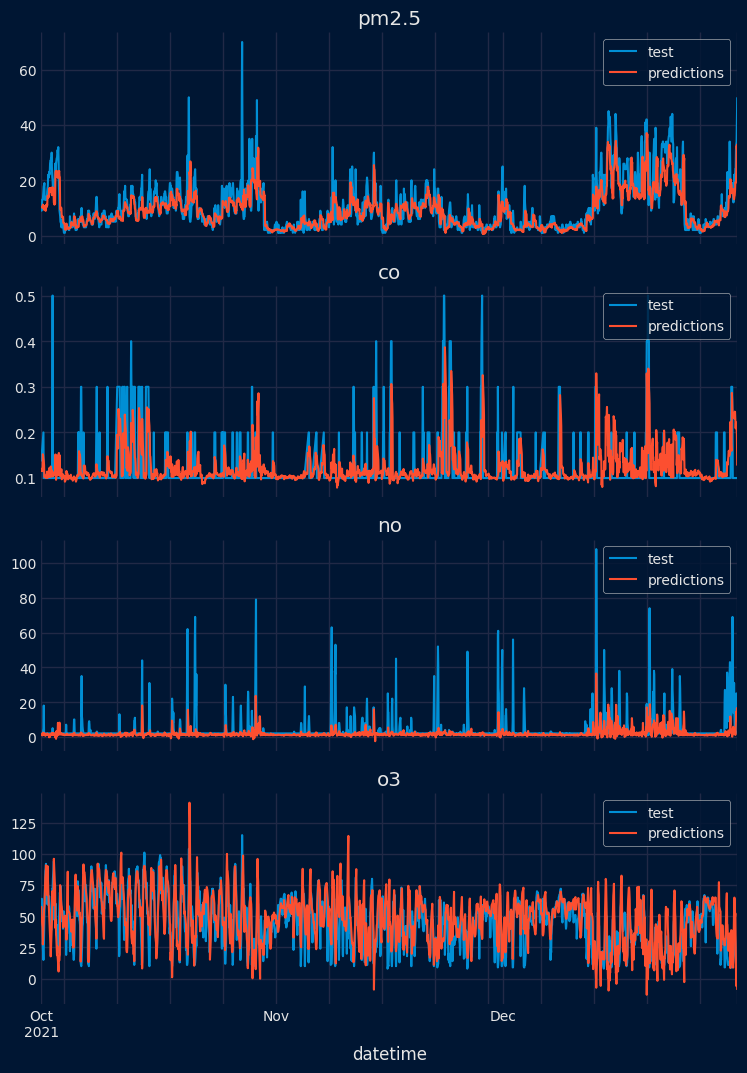

In [44]:
# Plot all the predicted variables as rows in the plot
# ==============================================================================
fig, ax = plt.subplots(len(levels), 1, figsize=(8, 3 * len(levels)), sharex=True)
for i, level in enumerate(levels):
    data_test[level].plot(ax=ax[i], label="test")
    predictions.loc[predictions["level"] == level, "pred"].plot(ax=ax[i], label="predictions")
    ax[i].set_title(level)
    ax[i].legend()

## Create and compile Tensorflow models

To improve the user experience and speed up the prototyping, development, and production process, skforecast has the `create_and_compile_model` function, with which, by indicating just a few arguments, the architecture is inferred and the model is created.

+ `series`: Time series to be used to train the model

+ `levels`: Time series to be predicted.
  
+ `lags`: Number of time steps to be used to predict the next value.

+ `steps`: Number of time steps to be predicted.

+ `recurrent_layer`: Type of recurrent layer to use. By default, an LSTM layer is used.
  
+ `recurrent_units`: Number of units in the recurrent layer. By default, 100 is used. If a list is passed, a recurrent layer will be created for each element in the list.

+ `dense_units`: Number of units in the dense layer. By default, 64 is used. If a list is passed, a dense layer will be created for each element in the list.
  
+ `optimizer`: Optimizer to use. By default, Adam with a learning rate of 0.01 is used.
  
+ `loss`: Loss function to use. By default, Mean Squared Error is used.


<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

The following examples use <code>recurrent_layer="LSTM"</code> but it is also possible to use <code>"RNN"</code> layers.

</div>

In [45]:
# Create model
# ==============================================================================
series = ["o3"]  # Series used as predictors
levels = ["o3"]  # Target series to predict
lags = 32        # Past time steps to be used to predict the target
steps = 1        # Future time steps to be predicted

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=4,
    dense_units=16,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 4)              │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 1, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In this case, a simple LSTM network is used, with a single recurrent layer with 4 neurons and a hidden dense layer with 16 neurons. The following table shows a detailed description of each layer:


| Layer                        | Type            | Output Shape      | Parameters  | Description                                                                                         |
|-----------------------------|-----------------|-------------------|-------------|-----------------------------------------------------------------------------------------------------|
| Input Layer (InputLayer)    | `InputLayer`    | `(None, 32, 1)`   | 0           | This is the input layer of the model. It receives sequences of length 32, corresponding to the number of lags with a dimension at each time step. |
| LSTM Layer (Long Short-Term Memory)| `LSTM`       | `(None, 4)`       | 96          | The LSTM layer is a long and short-term memory layer that processes the input sequence. It has 4 LSTM units and connects to the next layer.  |
| First Dense Layer (Dense)   | `Dense`         | `(None, 16)`      | 80          | This is a fully connected layer with 16 units and uses a default activation function (relu) in the provided architecture.     |
| Second Dense Layer (Dense)  | `Dense`         | `(None, 1)`       | 17          | Another fully connected dense layer, this time with a single output unit. It also uses a default activation function.          |
| Reshape Layer (Reshape)     | `Reshape`       | `(None, 1, 1)`    | 0           | This layer reshapes the output of the previous dense layer to have a specific shape `(None, 1, 1)`. This layer is not strictly necessary, but is included to make the module generalizable to other multi-output forecasting problems. The dimension of this output layer is `(None, steps_to_predict_future, series_to_predict)`. In this case, `steps=1 and levels="o3"`, so the dimension is `(None, 1, 1)`  |
| Total Parameters and Trainable | -           | -                 | 193         | Total Parameters: 193, Trainable Parameters: 193, Non-Trainable Parameters: 0               |


More complex models can be created including:

* Multiple series to be modeled (levels)
* Multiple series to be used as predictors (series)
* Multiple steps to be predicted (steps)
* Multiple lags to be used as predictors (lags)
* Multiple recurrent layers (recurrent_units)
* Multiple dense layers (dense_units)

In [46]:
# Model creation
# ==============================================================================
# Now, we have multiple series and multiple targets
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2'] 
levels = ['pm2.5', 'co', 'no', "o3"]  # Features to predict. It can be all the series or less
lags = 32 
steps = 5 

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 32, 100)        │        44,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 5, 4)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,604 (314.86 KB)

 Trainable params: 80,604 (314.86 KB)

 Non-trainable params: 0 (0.00 B)

## Running on GPU

The **skforecast** library is fully compatible with GPUs, enabling accelerated computation during model training when the appropriate hardware and software configurations are in place. If a compatible GPU is detected and properly configured, **skforecast** will automatically utilize the GPU to speed up the training process, especially for large and complex models.

### GPU Performance and Batch Size Considerations
The performance gains from using a GPU are most noticeable when training with larger batch sizes. This is because GPUs are optimized for parallel processing, and larger batches allow the GPU to process more data simultaneously. However, if the batch size is too small, the benefits of using the GPU over the CPU may be minimal.

- **Optimal Batch Size**: For most models, increasing the batch size to values such as **64**, **128**, or **1024** can yield significant performance improvements. Training with small batch sizes may result in the GPU performing similarly to the CPU.
- **Example Performance Gain**: For larger models and batches, you may experience substantial improvements in training times. For instance, on an **NVIDIA T4 GPU**, training time was reduced from **1m 20s** on the CPU to just **6 seconds** on the GPU when using larger batches.

### Setting Up and Using the GPU
To run models on the GPU using **skforecast**, ensure the following:
1. The GPU is properly installed and configured on your machine.
2. The necessary dependencies, including PyTorch with CUDA support, are installed.
3. The GPU is detected correctly by PyTorch using `torch.cuda.is_available()`.

Once these configurations are in place, no further modifications are needed to use the GPU with **skforecast**. The library will automatically leverage GPU resources when available, providing faster training times.

---

### Example Code: Model Creation and Training

```python
# Create model
# ==============================================================================
series = ["o3"]  # Series used as predictors
levels = ["o3"]  # Target series to predict
lags = 32  # Past time steps to be used to predict the target
steps = 1  # Future time steps to be predicted

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 100, 100, 100],
    dense_units=[64, 32, 16, 8],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

# Forecaster Definition
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 3,  # Number of epochs to train the model.
        "batch_size": 512,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)    

# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)
```

### Conclusion
Once your GPU is properly configured, **skforecast** will automatically detect it and accelerate training, reducing computation time significantly for larger models and datasets. The key to maximizing GPU performance lies in selecting an appropriate batch size. Larger batch sizes allow the GPU to utilize its parallel processing power effectively, leading to faster training times.

## Get training and test matrices

In [47]:
# Model creation
# ==============================================================================
series = ['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2'] 
levels = ['pm2.5', 'co', 'no', "o3"]  # Features to predict. It can be all the series or less
lags = 10 
steps = 5 

data = air_quality[series].copy()
data_train = air_quality_train[series].copy()
data_val = air_quality_val[series].copy()
data_test = air_quality_test[series].copy()

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)

forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    steps=steps,
    lags=lags,
)
forecaster

keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0


ForecasterRnn 
Regressor: <Functional name=functional_6, built=True> 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for series: MinMaxScaler() 
Window size: 10 
Target series, levels: ['pm2.5', 'co', 'no', 'o3'] 
Multivariate series (names): None 
Maximum steps predicted: [1 2 3 4 5] 
Training range: None 
Training index type: None 
Training index frequency: None 
Model parameters: {'name': 'functional_6', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 10, 10), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_6'}, 'registered_name': None, 'name': 'input_layer_6', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm_12', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'z

In [48]:
forecaster.create_train_X_y(data_train)[2]["X_train"][2]

['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2']

The RNN Forecaster can also be used to generate the X_train and y_train matrices that will be used to train the model. The `create_train_X_y` method allows the user to obtain the training and test matrices that will be used to train the model. The method return 3 elements: X_train, y_train, and dimension_information. The X_train matrix has dimensions `(n_samples, n_lags, n_series)`, while the y_train matrix has dimensions `(n_samples, n_steps, n_levels)`.



In [49]:
X_train, y_train, dimension_info = forecaster.create_train_X_y(data_train)

In [50]:
X_train.shape, y_train.shape

((19690, 10, 10), (19690, 5, 4))

The dimension_information dictionary contains the information of each dimension value for both X_train and y_train.

In [51]:
dimension_info["X_train"][0][:10]

[Timestamp('2019-01-01 10:00:00'),
 Timestamp('2019-01-01 11:00:00'),
 Timestamp('2019-01-01 12:00:00'),
 Timestamp('2019-01-01 13:00:00'),
 Timestamp('2019-01-01 14:00:00'),
 Timestamp('2019-01-01 15:00:00'),
 Timestamp('2019-01-01 16:00:00'),
 Timestamp('2019-01-01 17:00:00'),
 Timestamp('2019-01-01 18:00:00'),
 Timestamp('2019-01-01 19:00:00')]

In [52]:
dimension_info["X_train"][1]

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10']

In [53]:
dimension_info["X_train"][2]

['pm2.5', 'co', 'no', 'no2', 'pm10', 'nox', 'o3', 'veloc.', 'direc.', 'so2']

In [54]:
dimension_info["y_train"][0][:10]

[Timestamp('2019-01-01 10:00:00'),
 Timestamp('2019-01-01 11:00:00'),
 Timestamp('2019-01-01 12:00:00'),
 Timestamp('2019-01-01 13:00:00'),
 Timestamp('2019-01-01 14:00:00'),
 Timestamp('2019-01-01 15:00:00'),
 Timestamp('2019-01-01 16:00:00'),
 Timestamp('2019-01-01 17:00:00'),
 Timestamp('2019-01-01 18:00:00'),
 Timestamp('2019-01-01 19:00:00')]

In [55]:
dimension_info["y_train"][1]

['step_1', 'step_2', 'step_3', 'step_4', 'step_5']

In [56]:
dimension_info["y_train"][2]

['pm2.5', 'co', 'no', 'o3']